# Figure 3b: Estimation
In this Notebook, we shall create a plot showing the estimation performed through a Spike Coding Network (SCN). The plot shows the estimated states of the SCN Kalman filter, as well as the actual Spring-Mass-Damper (SMD) dynamical system which the SCN estimator is estimating. The work in this notebook is carried out for "Closed-form control with spike coding networks" by F.S. Slijkhuis, S.W. Keemink and P. Lanillos (https://doi.org/10.48550/arXiv.2212.12887).

## Imports
Nothing too special here, we shall use Numpy for matrices and Matplotlib for plotting. The Python-files initialization.py and simulation.py contain helper functions which will prevent clutter in this notebook. Please refer to the files themselves to learn more about the functions within them.

In [1]:
import numpy as np #Numpy for matrix calculations
import matplotlib.pyplot as plt #Matplotlib for plotting
import initialization, simulation #Helper functions for initialization and simulation are located in these two Python files. Please see the files themselves for more details.

## Initialization
For initialization, we shall define parameters relevant to the simulations in this notebook. As mentioned earlier, we are simulating both an SCN Kalman filter and an Spring-Mass-Damper system. Both will be simulated using Forward Euler. But first, we must define the relevant parameters.

In [2]:
#Forward Euler parameters
time = 50 #Total simulation time in seconds
dt = 0.001 #Length of a single timestep

#Spring-Mass-Damper System parameters
m = 3 #Mass (in kg)
k = 5 #Spring constant (in N/m)
c = 0.5 #Constant of proportionality (dampening, in Ns/m = kg/s)
x0 = np.array([5, 0]) #Initial state of the SMD system.

#Other system parameters
C = np.array([[1,0],
              [0,0]]) #Initialization of the C matrix (because y=Cx+noise)
Vn_cov = 0.001 #Sensor noise covariance (y=Cx+noise)
Vd_cov = 0.001 #Disturbance noise covariance (noise on the SMD)

#SCN Estimator parameters
network_size = 20 #The number of neurons in the SCN
signal_dimensions = 2 #The dimensions of the signal, K (is equal to the size of x0, but can be set manually)
lam = 0.1 #The leakage constant of the network, lambda
Vv_sigma = 0.000001 #Voltage noise sigma; noise on the voltage

Next, we shall run some of the code from initialization.py, required to initialize some of the parameters and matrices used in the simulation loop.

In [3]:
#Forward Euler simulation
times,Nt = initialization.FE_init(time,dt) #times is a list of timesteps which we will loop over, Nt is the total number of timesteps (length of times)

#SMD System A and B matrices
A,B = initialization.SMD_init(m,k,c) #A and B are the system matrix and input matrix in state-space representation (according to Ax+Bu)

#Initialization of the Kalman filter gain matrix to be used inside of the SCN estimator and idealized Kalman filter
Kf = initialization.Kalman_init(A,C,Vn_cov,Vd_cov) #From the A and C matrices and noise covariances, we can calculate the Kalman filter gain matrix

#Initialization of the state-matrix, containing the states of the simulated SMD system over time
X = initialization.X_init(x0,Nt) #Requires x0 as the first state of the simulated SMD system, and Nt for the matrix dimensions

#Initializaton of the SCN estimator, given parameters, we calculate D, T, V, s, r and all of the connectivity
D,T,V,s,r,O_f,O_s,F_i,O_k,F_k = initialization.KfSCN_init(signal_dimensions,Nt,A,B,C,Kf,network_size,lam)

#Initialization of other matrices used in simulation, U, Y, X_hat (state matrix of SCN estimator), X_hat_fe (state matrix of idealized Kalman filter), uDIST and uNOISE (noise matrices)
U,Y,X_hat,X_hat_fe,uDIST,uNOISE = initialization.KfLoop_init(X,A,B,C,x0,Nt,Vd_cov,Vn_cov)

Rank of controllability-matrix: 2


## Simulation
Now that we have defined all of the parameters we need, we can define how to run the simulation. For individual SMD and SCN steps, we shall make use of simulation.py.

In [4]:
def run_simulation(Nt,X,A,B,U,uDIST,dt,Y,C,uNOISE,r,s,V,D,T,lam,O_f,O_s,F_i,O_k,F_k,Vv_sigma,X_hat,X_hat_fe,Kf):
    #Looping over the entire range of Nt, we have all the timesteps in our simulation
    for t in range(Nt):
        #First, simulate one step of the simulated SMD system
        X[:,t+1] = simulation.run_DSlinearized_step(X[:,t],A,B,U[:,t],uDIST[:,t],dt)

        #Our Kalman filters only have access to Y, which is the partially observable state plus noise
        Y[:,t+1] = C@X[:,t+1] + uNOISE[:,t+1]

        #Simulate a single step of the SCN Kalman filter
        r[:,t+1],s[:,t+1],V[:,t+1] = simulation.run_KfSCN_step(Y[:,t],U[:,t],r[:,t],s[:,t],V[:,t],D,T,lam,O_f,O_s,F_i,O_k,F_k,C,t,dt,Vv_sigma)
        
        #Calculate the state estimated by our SCN Kalman filter by decoding the internal firing rates
        X_hat[:,t+1] = D@r[:,t+1]
        
        #Run a step of the idealized Kalman filter which we compare the SCN to
        X_hat_fe[:,t+1] = simulation.run_Kfidealized_step(X_hat_fe[:,t],A,B,U[:,t],Kf,Y[:,t],C,dt)

        #We set U to zero, since we are using no outside input in this estimation plot
        U[0,t+1] = 0
    
    return X_hat,X_hat_fe,X,Y,s

Next, we run a single simulation for plotting.

In [5]:
X_hat,X_hat_fe,X,Y,s = run_simulation(Nt,X,A,B,U,uDIST,dt,Y,C,uNOISE,r,s,V,D,T,lam,O_f,O_s,F_i,O_k,F_k,Vv_sigma,X_hat,X_hat_fe,Kf)

## Plotting
Now that we have obtained our filled state matrices, we can plot everything.

<Figure size 864x288 with 0 Axes>

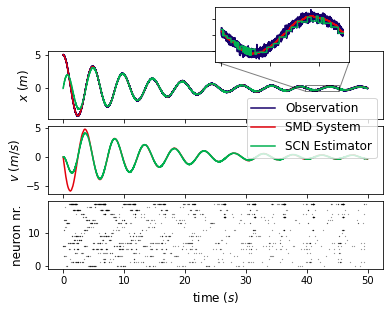

In [33]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(12)
fig, axs = plt.subplots(3,1, sharex=True, squeeze=True, gridspec_kw = {'hspace':0.1,'height_ratios':[1,1,1]})
legend_fontsize=12

legend=[]
axs[0].plot(np.arange(0,time+dt,dt),Y[0],color='#17006B')
legend.append("Observation")
#axs[0].plot(np.arange(0,Time+dt,dt),X_hat_fe[0],color='#0000FF',linewidth=3)
#legend.append("x̂$_{"+str(1)+"}$_FE")
axs[0].plot(np.arange(0,time+dt,dt),X[0],color='#E3000B')
legend.append("SMD System")
axs[0].plot(np.arange(0,time+dt,dt),X_hat[0],color='#00B050')
legend.append("SCN Estimator")

axs[1].plot(np.arange(0,time+dt,dt),X[1],color='#E3000B')
axs[1].plot(np.arange(0,time+dt,dt),X_hat[1],color='#00B050')
fig.legend(legend,fontsize=legend_fontsize,loc='upper right',bbox_to_anchor=(0.90,0.74))
    
axs[0].set_ylabel('$x$ $(m)$',fontsize = 12)
axs[1].set_ylabel('$v$ $(m/s)$',fontsize = 12)

#We use a scatterplot for the spike trains:
axs[2].scatter(np.nonzero(s)[1]/1000,np.nonzero(s)[0],marker=".",s=0.1,color='black')
axs[2].set_xlabel('time ($s$)',fontsize = 12)
axs[2].set_ylabel('neuron nr.',fontsize = 12)

axins = axs[0].inset_axes([0.5, 0.85, 0.4, 0.8])
range_plot_x,range_plot_y=40000,45000
axins.plot(np.arange(0,time+dt,dt)[range_plot_x:range_plot_y],Y[0,range_plot_x:range_plot_y],color='#17006B') #0070C0
axins.plot(np.arange(0,time+dt,dt)[range_plot_x:range_plot_y],X[0,range_plot_x:range_plot_y],color='#E3000B')
axins.plot(np.arange(0,time+dt,dt)[range_plot_x:range_plot_y],X_hat[0,range_plot_x:range_plot_y],color='#00B050')
axins.set_xticklabels([])
axins.set_yticklabels([])

axs[0].indicate_inset_zoom(axins, edgecolor="black")

plt.savefig('./img/fig3b.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.show()